# Feed Forward Neural Network

In this chapter, we're going to do a simple exercise about feed forward neural network.

Feed forward Neural network is a multi-layer network of linear combinations and non-linear activation functions.

As FFNN contains both linear and non-linear aspects, it is expected to be able to learn any function possible.

In [ ]:
$ luarocks install mnist

# MNIST dataset

MNIST is a handwritten digits database, which contains 10 classes of handwritten digits of 0~9.

It is a very popular dataset for those who are first studying machine learning or deep learning algorithms.

It contains of 60000 training dataset and 10000 test dataset.

Each label contains 6000 images of handwritten digits, which is in

grayscale image(which means that unlike normal color image which has 

3 values of channels R, G, B, this dataset consists of only one layer

that represents saturation.)

In [1]:
require 'torch'
require 'nn'
require 'optim'
mnist = require 'mnist'

In [2]:
print '============================================='
print '=> Loading MNIST dataset...'
print '============================================='

trainData = mnist.traindataset()
testData = mnist.testdataset()


=> Loading MNIST dataset...	


In [3]:
-- checking ouy
print '============================================='
print("=> Checking Data...")
print '=============================================\n'
print("Training Set : ")
print(trainData)
print()
print("Training Label : ")
print(trainData.label:size())
print("Test Set : ")
print(testData)
print("Test Label : ")
print(testData.label:size())

=> Checking Data...	
	
Training Set : 	
{
  data : ByteTensor - size: 60000x28x28
  size : 60000
  label : ByteTensor - size: 60000
}

Training Label : 	
 60000
[torch.LongStorage of size 1]

Test Set : 	
{
  data : ByteTensor - size: 10000x28x28
  size : 10000
  label : ByteTensor - size: 10000
}
Test Label : 	
 10000
[torch.LongStorage of size 1]



=> Visualizing Data...	
	
Training data : 	


Test data : 	


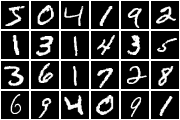

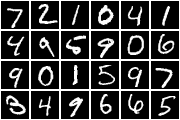

In [4]:
print '============================================='
print('=> Visualizing Data...')
print '=============================================\n'

if itorch then
    print('Training data : ')
    itorch.image(trainData.data[{ {1,24} }])
    print('Test data : ')
    itorch.image(testData.data[{ {1,24} }])
end

# Model definition

We will use a model with 2 hidden layers, using sigmoid activation,

and add a single softmax layer on the output.

As an input, we will spread out the (28, 28) image into a single row with 784(=28*28) nodules.

In [5]:
model = nn.Sequential()
model:add(nn.Reshape(28*28))
model:add(nn.Linear(28*28, 30))
model:add(nn.Sigmoid())
model:add(nn.Linear(30, 30))
model:add(nn.Sigmoid())
model:add(nn.Linear(30, 10)) -- As the classifier has 10 classes
model:add(nn.LogSoftMax())

# Criterion definition

Torch provides various criterions enabling the user to train various models with various methods.

In this section, we will use the ClassNLLCriterion.

The NLL criterion needs the output to be in a log-probability format in order to calculate the loss and update the weights.

In [6]:
criterion = nn.ClassNLLCriterion()

# GPU function

The below codes enables the model to train on the GPU you own.

You must have already completed the GPU settings in order to 

train by this option.

In [7]:
require 'cutorch'
require 'cudnn'
require 'cunn'

GPU_flag = false

if GPU_flag then
    model:cuda()
    criterion:cuda()
else
    model:double()
    criterion:double()
end

# Optimizer Definition

There are various descent algorithms other than SGD(Stochastic Gradient Descent), but we will continue to use SGD as our default optimizer.

In [8]:
sgd_params = {
   learningRate = 1e-2,
   learningRateDecay = 1e-4,
   weightDecay = 1e-3,
   momentum = 0.05
}

In [9]:
x, dl_dx = model:getParameters()

# Mini-batch SGD

In contrast to the chapters before, from now on we're going to adapt mini-batch SGD.

Gradient Descent performs best when it's batch equals it's training size, but for many reasons and for many cases, that simply isn't possible.

So, as a median offer for Gradient Descent(Batch size = training size) and Stochastic Gradient Descent(Batch size = 1), mini-batch SGD takes a fixed amount of batches into its input.

It results in much faster and much efficient training than Stochastic Gradient Descent, with consuming much less memory than Full-batch Gradient Descent.

In [10]:
-- Mini-batch SGD function
mini_batch_upload = function(GPU_flag, batch_size)
    local current_loss = 0
    local count = 0
    local shuffle = torch.randperm(trainData.size)
    batch_size = batch_size or 128
    
    for t = 1,trainData.size,batch_size do
        -- setup inputs and targets for this mini-batch
        local size = math.min(t + batch_size - 1, trainData.size) - t
        if GPU_flag then
            inputs = torch.Tensor(size, 28, 28):cuda()
        else
            inputs = torch.Tensor(size, 28, 28)
        end
        
        -- definition of target data
        local targets = torch.Tensor(size)
        
        -- Batch iteration
        for i = 1,size do
            local input = trainData.data[shuffle[i+t]]
            if GPU_flag then
                input:cuda()
            end
            local target = trainData.label[shuffle[i+t]]
            -- if target == 0 then target = 10 end
            inputs[i] = input
            targets[i] = target
        end
        targets:add(1)
        
        local feval = function(x_new)
            -- reset data
            if x ~= x_new then x:copy(x_new) end
            dl_dx:zero()

            -- perform mini-batch gradient descent
            local loss = criterion:forward(model:forward(inputs), targets)
            model:backward(inputs, criterion:backward(model.output, targets))

            return loss, dl_dx
        end
        
        _, fs = optim.sgd(feval, x, sgd_params)
        -- fs is a table containing value of the loss function
        -- (just 1 value for the SGD optimization)
        count = count + 1
        current_loss = current_loss + fs[1]
    end

    -- normalize loss
    return current_loss / count
end

# Testing Dataset

For evaluating accuracy on the validation dataset.

Validation dataset is needed to check if whether the training is being successful and also checking if there is no overfitting or underfitting taking place.

Simple sign of overfitting is training loss being much lesser than the validation loss, while sign of underfitting will be training loss not decreasing from a certain point.

In [11]:
eval = function(dataset, GPU_flag, batch_size)
    local count = 0
    batch_size = batch_size or 128
    
    for i = 1,dataset.size,batch_size do
        local size = math.min(i + batch_size - 1, dataset.size) - i
        -- Important
        -- The arguement set only accepts Double Tensor as an input!
        if GPU_flag then
            inputs = dataset.data[{{i,i+size-1}}]:cuda()
        else
            inputs = dataset.data[{{i,i+size-1}}]:double()
        end
        
        -- definition of target label
        if GPU_flag then 
            local tmp = dataset.label[{{i,i+size-1}}]:long()
            targets = torch.CudaLongTensor()
            targets:resize(tmp:size()):copy(tmp)
        else
            targets = dataset.label[{{i,i+size-1}}]:long()
        end
        
        -- feed forward neural network
        local outputs = model:forward(inputs)
        local _, indices = torch.max(outputs, 2)
        indices:add(-1)
        local guessed_right = indices:eq(targets):sum()
        count = count + guessed_right
    end

    return count / dataset.size
end

# Training the model

Now on, we will start to train the model.

In [12]:
local epochs = 30
local last_accurcay = 0

for i = 1,epochs do
    local loss = mini_batch_upload(GPU_flag)
    print(string.format('Epoch #%d : Loss = %4f', i, loss))
    local accuracy = eval(testData, GPU_flag)
    print(string.format('Test accuracy : %4f', accuracy*100)..'%')
    last_accuracy = accuracy
end

print("\n\nTraining Progress Finished!")
print(string.format('Final Test acc : %4f', last_accuracy*100)..'%')

Epoch #1 : Loss = 2.233233	


Test accuracy : 36.450000%	


Epoch #2 : Loss = 2.107554	


Test accuracy : 61.040000%	


Epoch #3 : Loss = 1.961850	


Test accuracy : 64.580000%	


Epoch #4 : Loss = 1.781929	


Test accuracy : 68.500000%	


Epoch #5 : Loss = 1.594902	


Test accuracy : 70.710000%	


Epoch #6 : Loss = 1.422571	


Test accuracy : 74.340000%	


Epoch #7 : Loss = 1.274314	


Test accuracy : 75.650000%	


Epoch #8 : Loss = 1.150045	


Test accuracy : 78.260000%	


Epoch #9 : Loss = 1.047305	


Test accuracy : 81.480000%	


Epoch #10 : Loss = 0.964245	


Test accuracy : 81.810000%	


Epoch #11 : Loss = 0.894907	


Test accuracy : 82.930000%	


Epoch #12 : Loss = 0.837978	


Test accuracy : 83.340000%	


Epoch #13 : Loss = 0.789844	


Test accuracy : 84.700000%	


Epoch #14 : Loss = 0.748695	


Test accuracy : 85.380000%	


Epoch #15 : Loss = 0.713131	


Test accuracy : 86.830000%	


Epoch #16 : Loss = 0.682871	


Test accuracy : 86.970000%	


Epoch #17 : Loss = 0.655593	


Test accuracy : 87.060000%	


Epoch #18 : Loss = 0.631198	


Test accuracy : 87.410000%	


Epoch #19 : Loss = 0.609298	


Test accuracy : 87.380000%	


Epoch #20 : Loss = 0.590598	


Test accuracy : 87.770000%	


Epoch #21 : Loss = 0.572657	


Test accuracy : 87.590000%	


Epoch #22 : Loss = 0.556287	


Test accuracy : 88.210000%	


Epoch #23 : Loss = 0.542398	


Test accuracy : 88.490000%	


Epoch #24 : Loss = 0.527591	


Test accuracy : 88.030000%	


Epoch #25 : Loss = 0.516059	


Test accuracy : 88.310000%	


Epoch #26 : Loss = 0.503007	


Test accuracy : 88.480000%	


Epoch #27 : Loss = 0.493574	


Test accuracy : 88.450000%	


Epoch #28 : Loss = 0.483961	


Test accuracy : 88.950000%	


Epoch #29 : Loss = 0.473794	


Test accuracy : 88.990000%	


Epoch #30 : Loss = 0.464411	


Test accuracy : 89.150000%	


Training Progress Finished!	
Final Test acc : 89.150000%	


In [14]:
torch.save('./bestmodel.t7', model)

In [15]:
model = torch.load('./bestmodel.t7')

In [21]:
print("Loaded Test Accuracy : "..(eval(testData, GPU_flag)*100)..'%')

Loaded Test Accuracy : 89.15%	
